In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train = pd.read_csv("train_final.csv", index_col=['date'], parse_dates=['date'])
test = pd.read_csv("test_final.csv", index_col=['date'], parse_dates=['date'])

In [3]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import prophet
import itertools

In [6]:
# build the model with one country with highest GDP per capita in each continent
# if data of multiple regions are available, use one region
# then apply the model to other countries in same continent
Luxembourg_train = train.loc[train.country_code == 'LU','new_confirmed'] # Europe
Singapore_train = train.loc[train.country_code == 'SG','new_confirmed'] # Asia
US_train = train.loc[train.location_key_x == 'US_AK','new_confirmed'] # North America
Australia_train = train.loc[train.location_key_x == 'AU_NT','new_confirmed'] # Oceania
Luxembourg_test = test.loc[test.country_code == 'LU','new_confirmed']
Singapore_test = test.loc[test.country_code == 'SG','new_confirmed']
US_test = test.loc[test.location_key_x == 'US_AK','new_confirmed']
Australia_test = test.loc[test.location_key_x == 'AU_NT','new_confirmed']

In [57]:
Luxembourg_model = prophet.Prophet().fit(Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/00gkt5kq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/1skkdrpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2188', 'data', 'file=/tmp/tmpedbxqiql/00gkt5kq.json', 'init=/tmp/tmpedbxqiql/1skkdrpe.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelfrrlo7hn/prophet_model-20231124051058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:10:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:10:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [58]:
Luxembourg_train_pred=Luxembourg_model.predict(Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Luxembourg_train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-03-01,-37.012317,-321.353111,13.107254,-37.012317,-37.012317,-117.836452,-117.836452,-117.836452,-117.836452,-117.836452,-117.836452,0.0,0.0,0.0,-154.848770
2020-03-02,-36.255629,-237.345100,117.557872,-36.255629,-36.255629,-32.162384,-32.162384,-32.162384,-32.162384,-32.162384,-32.162384,0.0,0.0,0.0,-68.418013
2020-03-03,-35.498940,-138.386139,207.019615,-35.498940,-35.498940,68.772973,68.772973,68.772973,68.772973,68.772973,68.772973,0.0,0.0,0.0,33.274033
2020-03-04,-34.742251,-156.113704,180.243092,-34.742251,-34.742251,42.373568,42.373568,42.373568,42.373568,42.373568,42.373568,0.0,0.0,0.0,7.631316
2020-03-05,-33.985563,-181.690520,164.850954,-33.985563,-33.985563,20.826319,20.826319,20.826319,20.826319,20.826319,20.826319,0.0,0.0,0.0,-13.159244


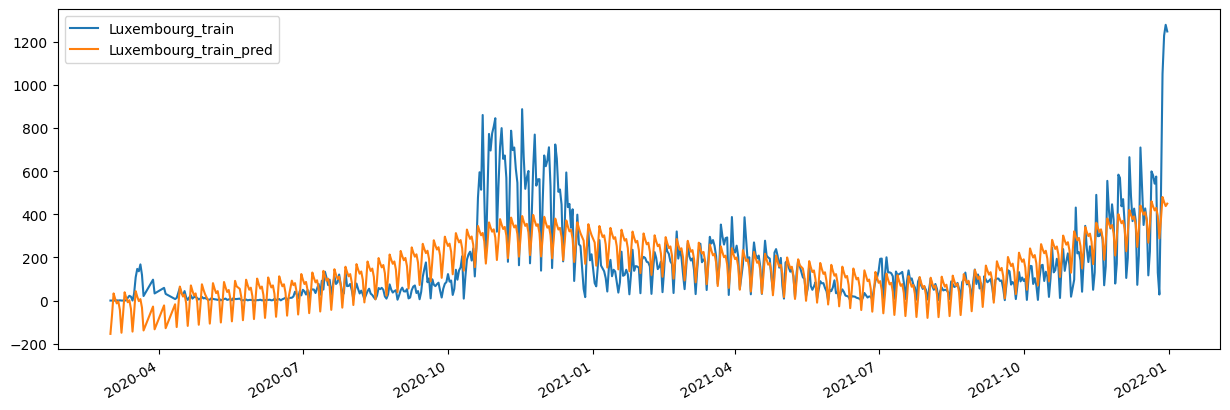

In [59]:
Luxembourg_train_pred_date = pd.DataFrame(Luxembourg_train_pred.index)
pd.concat([Luxembourg_train,Luxembourg_train_pred.yhat], axis=1).plot(figsize=(15,5))
plt.legend(['Luxembourg_train', 'Luxembourg_train_pred'])

In [60]:
# Luxerberg model training rmse without tuning
np.sqrt(mean_squared_error(Luxembourg_train,Luxembourg_train_pred.yhat))

132.03040258399787

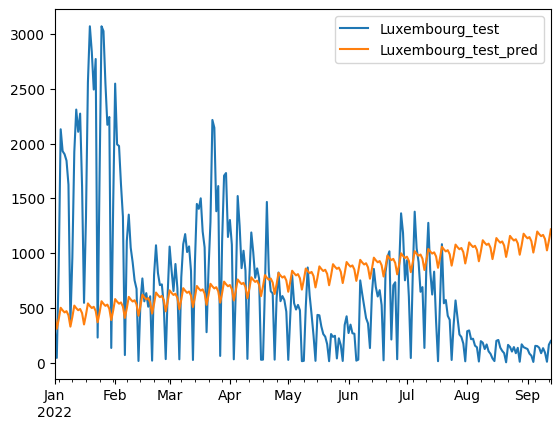

In [61]:
Luxembourg_test_pred=Luxembourg_model.predict(Luxembourg_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
pd.concat([Luxembourg_test,Luxembourg_test_pred['yhat']], axis=1).plot( )
plt.legend(['Luxembourg_test', 'Luxembourg_test_pred'])

In [62]:
# Luxerberg model teset rmse without tuning
np.sqrt(mean_squared_error(Luxembourg_test,Luxembourg_test_pred['yhat']))

811.130779243999

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 10.0]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters).fit(Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    Luxembourg_cv = cross_validation(prophet_model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    Luxembourg_performance = performance_metrics(Luxembourg_cv, rolling_window=1)
    rmses.append(Luxembourg_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [42]:
print(best_params)

{'changepoint_prior_scale': 0.9, 'seasonality_prior_scale': 10.0}


In [43]:
# Luxembourg model after tuning
Luxembourg_model_final = prophet.Prophet(changepoint_prior_scale = 0.9, seasonality_prior_scale = 10).fit(Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Luxembourg_train_pred_final=Luxembourg_model_final.predict(Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Luxembourg_test_pred_final=Luxembourg_model_final.predict(Luxembourg_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/ny2zqfqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/noeww7am.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42833', 'data', 'file=/tmp/tmpedbxqiql/ny2zqfqa.json', 'init=/tmp/tmpedbxqiql/noeww7am.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_model456__4zk/prophet_model-20231124050605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:06:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:06:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [44]:
# Luxerberg final model training rmse
np.sqrt(mean_squared_error(Luxembourg_train,Luxembourg_train_pred_final['yhat']))

94.21369273829825

In [45]:
# Luxerberg final model test rmse
np.sqrt(mean_squared_error(Luxembourg_test,Luxembourg_test_pred_final['yhat']))

904.4193743534901

In [12]:
Singapore_model = prophet.Prophet().fit(Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/mvnwyqzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/zpv58wxh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54989', 'data', 'file=/tmp/tmpedbxqiql/mvnwyqzg.json', 'init=/tmp/tmpedbxqiql/zpv58wxh.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelqvjn84mj/prophet_model-20231124033449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
Singapore_train_pred=Singapore_model.predict(Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Singapore_train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-03-01,338.689454,-494.603227,1161.613184,338.689454,338.689454,-55.723234,-55.723234,-55.723234,-55.723234,-55.723234,-55.723234,0.0,0.0,0.0,282.966220
2020-03-02,337.709234,-424.708803,1212.727893,337.709234,337.709234,15.606676,15.606676,15.606676,15.606676,15.606676,15.606676,0.0,0.0,0.0,353.315911
2020-03-03,336.729015,-451.288910,1256.550698,336.729015,336.729015,76.995764,76.995764,76.995764,76.995764,76.995764,76.995764,0.0,0.0,0.0,413.724778
2020-03-04,335.748795,-513.123804,1197.578671,335.748795,335.748795,-1.450166,-1.450166,-1.450166,-1.450166,-1.450166,-1.450166,0.0,0.0,0.0,334.298629
2020-03-05,334.768575,-450.353270,1210.144195,334.768575,334.768575,4.190307,4.190307,4.190307,4.190307,4.190307,4.190307,0.0,0.0,0.0,338.958882


In [39]:
# Singapore model training rmse without tuning
np.sqrt(mean_squared_error(Singapore_train,Singapore_train_pred['yhat']))

645.9992905938375

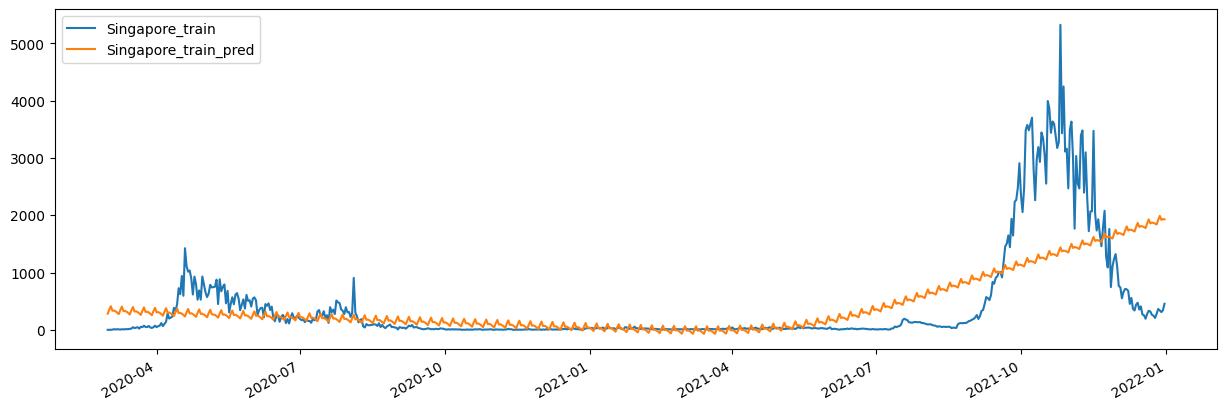

In [14]:
Singapore_train_pred_date = pd.DataFrame(Singapore_train_pred.index)
pd.concat([Singapore_train,Singapore_train_pred.yhat], axis=1).plot(figsize=(15,5))
plt.legend(['Singapore_train', 'Singapore_train_pred'])

In [40]:
# Singapore model test rmse without tuning
np.sqrt(mean_squared_error(Singapore_test,Singapore_test_pred['yhat']))

7497.66727270135

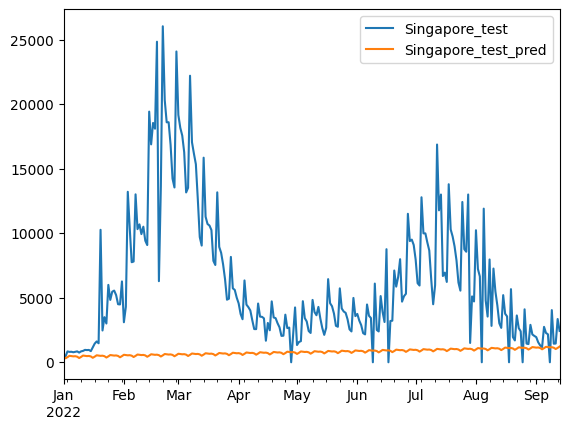

In [15]:
Singapore_test_pred=Luxembourg_model.predict(Singapore_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
pd.concat([Singapore_test,Singapore_test_pred['yhat']], axis=1).plot( )
plt.legend(['Singapore_test', 'Singapore_test_pred'])

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 8, 10.0,15]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters).fit(Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    Singapore_cv = cross_validation(prophet_model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    Singapore_performance = performance_metrics(Singapore_cv, rolling_window=1)
    rmses.append(Singapore_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [47]:
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


In [73]:
# Singapore model after tuning
Singapore_model_final = prophet.Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 0.1).fit(Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Singapore_train_pred_final=Singapore_model_final.predict(Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Singapore_test_pred_final=Singapore_model_final.predict(Singapore_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/df7iis74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/86myj8dh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50421', 'data', 'file=/tmp/tmpedbxqiql/df7iis74.json', 'init=/tmp/tmpedbxqiql/86myj8dh.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelbhckfm23/prophet_model-20231124051545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:15:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [74]:
# Singapore final model training rmse
np.sqrt(mean_squared_error(Singapore_train,Singapore_train_pred_final['yhat']))

791.8839076161833

In [75]:
# Singapore final model test rmse
np.sqrt(mean_squared_error(Singapore_test,Singapore_test_pred_final['yhat']))

7384.0674991982105

In [16]:
US_model = prophet.Prophet().fit(US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/uxxgaiz7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/it_98wsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74536', 'data', 'file=/tmp/tmpedbxqiql/uxxgaiz7.json', 'init=/tmp/tmpedbxqiql/it_98wsh.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modela6vp84iq/prophet_model-20231124033503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:35:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
US_train_pred=US_model.predict(US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
US_train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-03-01,-70.828817,-397.676000,123.362300,-70.828817,-70.828817,-68.271177,-68.271177,-68.271177,-68.271177,-68.271177,-68.271177,0.0,0.0,0.0,-139.099994
2020-03-02,-69.517135,-372.653163,152.915468,-69.517135,-69.517135,-33.501295,-33.501295,-33.501295,-33.501295,-33.501295,-33.501295,0.0,0.0,0.0,-103.018429
2020-03-03,-68.205453,-309.649439,217.780682,-68.205453,-68.205453,31.660644,31.660644,31.660644,31.660644,31.660644,31.660644,0.0,0.0,0.0,-36.544809
2020-03-04,-66.893771,-303.209140,236.904698,-66.893771,-66.893771,34.324680,34.324680,34.324680,34.324680,34.324680,34.324680,0.0,0.0,0.0,-32.569091
2020-03-05,-65.582090,-292.008908,227.137970,-65.582090,-65.582090,31.446750,31.446750,31.446750,31.446750,31.446750,31.446750,0.0,0.0,0.0,-34.135340


In [69]:
# US model training rmse without tuning
np.sqrt(mean_squared_error(US_train,US_train_pred['yhat']))

207.6217685449149

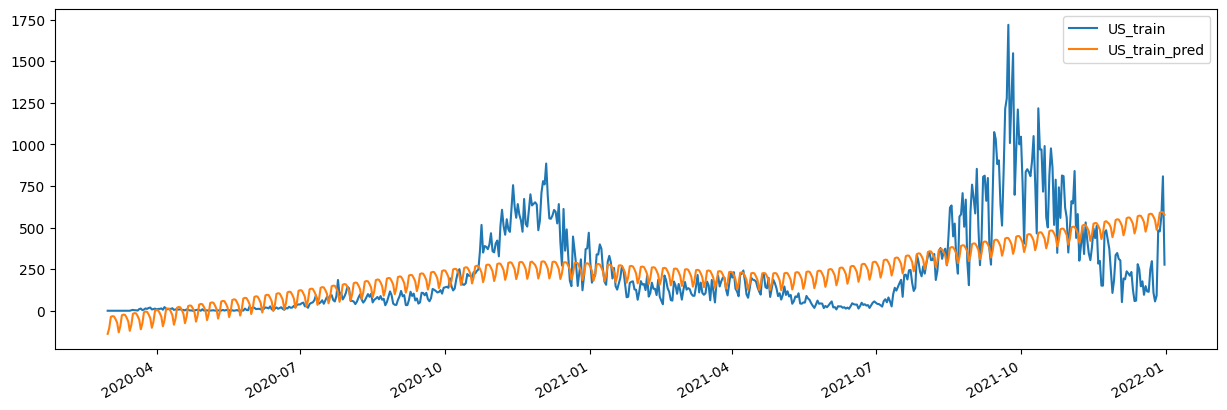

In [18]:
US_train_pred_date = pd.DataFrame(US_train_pred.index)
pd.concat([US_train,US_train_pred.yhat], axis=1).plot(figsize=(15,5))
plt.legend(['US_train', 'US_train_pred'])

In [70]:
# US model test rmse without tuning
np.sqrt(mean_squared_error(US_test,US_test_pred['yhat']))

764.3922398013407

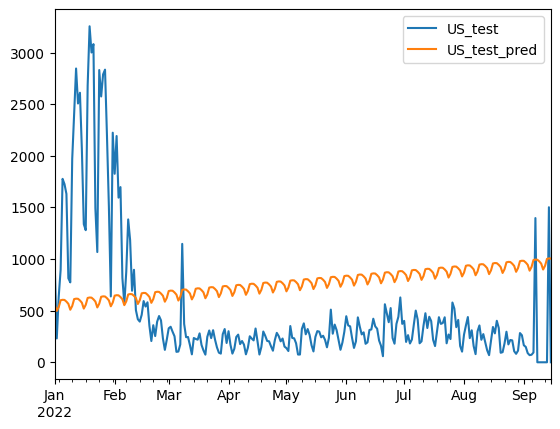

In [19]:
US_test_pred=US_model.predict(US_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
pd.concat([US_test,US_test_pred['yhat']], axis=1).plot( )
plt.legend(['US_test', 'US_test_pred'])

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 8, 10.0,15]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters).fit(US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    US_cv = cross_validation(prophet_model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    US_performance = performance_metrics(US_cv, rolling_window=1)
    rmses.append(US_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [72]:
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


In [76]:
# US model after tuning
US_model_final = prophet.Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 0.1).fit(US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
US_train_pred_final=US_model_final.predict(US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
US_test_pred_final=US_model_final.predict(US_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/fxfypevt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/9c8vpifn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87543', 'data', 'file=/tmp/tmpedbxqiql/fxfypevt.json', 'init=/tmp/tmpedbxqiql/9c8vpifn.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelbuuzlw2y/prophet_model-20231124052149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [77]:
# US final model training rmse
np.sqrt(mean_squared_error(US_train,US_train_pred_final['yhat']))

232.57512785165682

In [78]:
# US final model test rmse
np.sqrt(mean_squared_error(US_test,US_test_pred_final['yhat']))

668.4559080332689

In [ ]:
Australia_model = prophet.Prophet().fit(Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

In [21]:
Australia_train_pred=Australia_model.predict(Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Australia_train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-03-01,0.205462,-3.903402,3.888252,0.205462,0.205462,-0.187487,-0.187487,-0.187487,-0.187487,-0.187487,-0.187487,0.0,0.0,0.0,0.017974
2020-03-02,0.206057,-4.022518,3.702200,0.206057,0.206057,-0.287993,-0.287993,-0.287993,-0.287993,-0.287993,-0.287993,0.0,0.0,0.0,-0.081936
2020-03-03,0.206652,-3.510592,3.900254,0.206652,0.206652,-0.089284,-0.089284,-0.089284,-0.089284,-0.089284,-0.089284,0.0,0.0,0.0,0.117368
2020-03-04,0.207247,-3.625798,4.011359,0.207247,0.207247,-0.046783,-0.046783,-0.046783,-0.046783,-0.046783,-0.046783,0.0,0.0,0.0,0.160464
2020-03-05,0.207842,-3.368007,4.156790,0.207842,0.207842,0.380434,0.380434,0.380434,0.380434,0.380434,0.380434,0.0,0.0,0.0,0.588276


In [83]:
# Australia model training rmse without tuning
np.sqrt(mean_squared_error(Australia_train,Australia_train_pred['yhat']))

3.0021407160766667

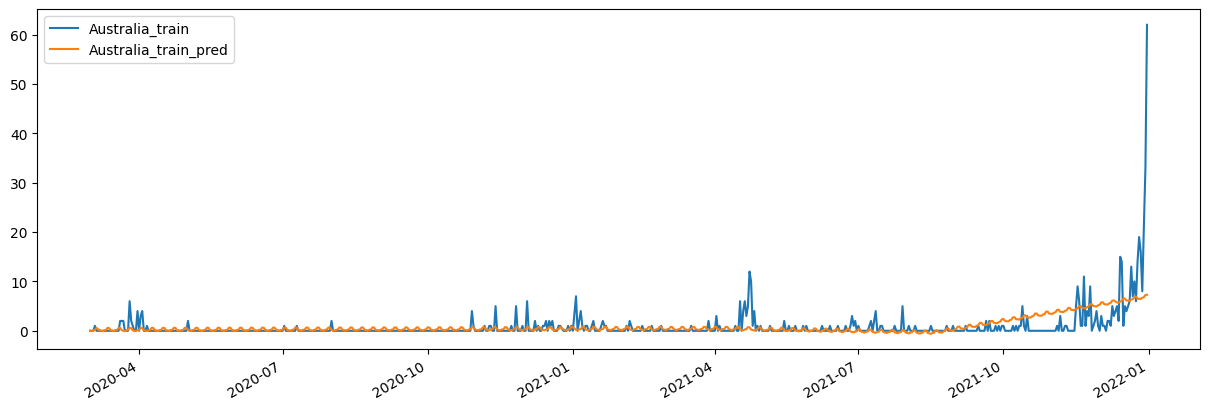

In [22]:
Australia_train_pred_date = pd.DataFrame(Australia_train_pred.index)
pd.concat([Australia_train,Australia_train_pred.yhat], axis=1).plot(figsize=(15,5))
plt.legend(['Australia_train', 'Australia_train_pred'])

In [84]:
# Australia model training rmse without tuning
np.sqrt(mean_squared_error(Australia_test,Australia_test_pred['yhat']))

592.9675068778747

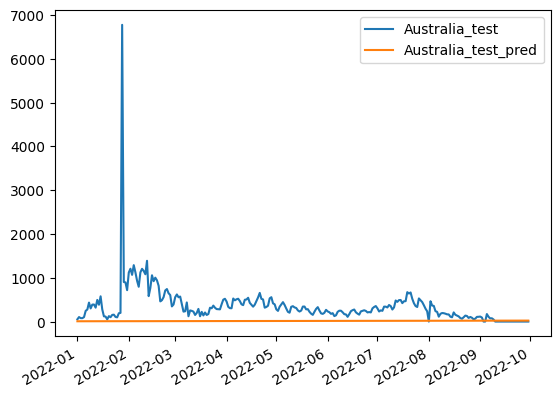

In [23]:
Australia_test_pred=Australia_model.predict(Australia_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
pd.concat([Australia_test,Australia_test_pred['yhat']], axis=1).plot( )
plt.legend(['Australia_test', 'Australia_test_pred'])

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 8, 10.0,15]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters).fit(Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    Australia_cv = cross_validation(prophet_model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    Australia_performance = performance_metrics(Australia_cv, rolling_window=1)
    rmses.append(Australia_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [86]:
print(best_params)

{'changepoint_prior_scale': 0.8, 'seasonality_prior_scale': 1.0}


In [87]:
# Australia model after tuning
Australia_model_final = prophet.Prophet(changepoint_prior_scale = 0.8, seasonality_prior_scale = 1).fit(Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Australia_train_pred_final=Australia_model_final.predict(Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Australia_test_pred_final=Australia_model_final.predict(Australia_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/lmq86z3y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/s2_bw2ax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90931', 'data', 'file=/tmp/tmpedbxqiql/lmq86z3y.json', 'init=/tmp/tmpedbxqiql/s2_bw2ax.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelf1r2_i9h/prophet_model-20231124053517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:35:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [88]:
# Australia final model training rmse
np.sqrt(mean_squared_error(Australia_train,Australia_train_pred_final['yhat']))

2.9270103805963528

In [89]:
# Australia final model test rmse
np.sqrt(mean_squared_error(Australia_test,Australia_test_pred_final['yhat']))

590.756533131647

In [91]:
# apply to all countries
# Luxembourg_model_final for European countries
# Singapore_model_final for Asian countries
# US_model_final for countries in North America - only US in top 10
# Australia_model_final for Oceania countries - only Australia in top 10
Ireland_train = train.loc[train.country_code == 'IE','new_confirmed'] # Europe
Norway_train = train.loc[train.country_code == 'NO','new_confirmed'] # Europe
Switzerland_train = train.loc[train.country_code == 'CH','new_confirmed'] # Europe
Qatar_train = train.loc[train.country_code == 'QA','new_confirmed'] # Asia
Iceland_train = train.loc[train.country_code == 'IS','new_confirmed'] # Europe
Denmark_train = train.loc[train.country_code == 'DK','new_confirmed'] # Europe

Ireland_test = test.loc[test.country_code == 'IE','new_confirmed'] # Europe
Norway_test = test.loc[test.country_code == 'NO','new_confirmed'] # Europe
Switzerland_test = test.loc[test.country_code == 'CH','new_confirmed'] # Europe
Qatar_test = test.loc[test.country_code == 'QA','new_confirmed'] # Asia
Iceland_test = test.loc[test.country_code == 'IS','new_confirmed'] # Europe
Denmark_test = test.loc[test.country_code == 'DK','new_confirmed'] # Europe

In [117]:
#rmse for Ireland using default prophet model
default_model = prophet.Prophet().fit(Ireland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Ireland_train_pred=default_model.predict(Ireland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Ireland_test_pred=default_model.predict(Ireland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
print('Using default Prophet model, training rmse for Ireland is',np.sqrt(mean_squared_error(Ireland_train,Ireland_train_pred['yhat'])))
print('Using default Prophet model, test rmse for Ireland is',np.sqrt(mean_squared_error(Ireland_test,Ireland_test_pred['yhat'])))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/12g97ls2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/jf8clz5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29256', 'data', 'file=/tmp/tmpedbxqiql/12g97ls2.json', 'init=/tmp/tmpedbxqiql/jf8clz5x.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_model6vnpmjhk/prophet_model-20231124060842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Using default Prophet model, training rmse for Ireland is 1437.0772335219665
Using default Prophet model, test rmse for Ireland is 11685.360158106507


In [92]:
# Ireland using Luxembourg final model
Ireland_train_pred_final=Luxembourg_model_final.predict(Ireland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Ireland_test_pred_final=Luxembourg_model_final.predict(Ireland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [101]:
# Ireland training rmse
np.sqrt(mean_squared_error(Ireland_train,Ireland_train_pred_final['yhat']))

2375.9636694203145

In [102]:
# Ireland test rmse
np.sqrt(mean_squared_error(Ireland_test,Ireland_test_pred_final['yhat']))

5345.235731211001

In [118]:
#rmse for Norway using default prophet model
default_model = prophet.Prophet().fit(Norway_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Norway_train_pred=default_model.predict(Norway_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Norway_test_pred=default_model.predict(Norway_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
print('Using default Prophet model, training rmse for Norway is',np.sqrt(mean_squared_error(Norway_train,Norway_train_pred['yhat'])))
print('Using default Prophet model, test rmse for Norway is',np.sqrt(mean_squared_error(Norway_test,Norway_test_pred['yhat'])))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/j60u7or2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/cxp2pml5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71763', 'data', 'file=/tmp/tmpedbxqiql/j60u7or2.json', 'init=/tmp/tmpedbxqiql/cxp2pml5.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelkzli8se0/prophet_model-20231124060953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:09:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Using default Prophet model, training rmse for Norway is 207.00761460260645
Using default Prophet model, test rmse for Norway is 1107.122346094917


In [95]:
# Norway using Luxembourg final model
Norway_train_pred_final=Luxembourg_model_final.predict(Norway_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Norway_test_pred_final=Luxembourg_model_final.predict(Norway_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [99]:
# Norway training rmse
np.sqrt(mean_squared_error(Norway_train,Norway_train_pred_final['yhat']))

279.1142361551507

In [100]:
# Norway test rmse
np.sqrt(mean_squared_error(Norway_test,Norway_test_pred_final['yhat']))

1260.7341109207748

In [119]:
#rmse for Switzerland using default prophet model
default_model = prophet.Prophet().fit(Switzerland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Switzerland_train_pred=default_model.predict(Switzerland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Switzerland_test_pred=default_model.predict(Switzerland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
print('Using default Prophet model, training rmse for Switzerland is',np.sqrt(mean_squared_error(Switzerland_train,Switzerland_train_pred['yhat'])))
print('Using default Prophet model, test rmse for Switzerland is',np.sqrt(mean_squared_error(Switzerland_test,Switzerland_test_pred['yhat'])))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/fiazmfwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/3vgtgfu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64512', 'data', 'file=/tmp/tmpedbxqiql/fiazmfwh.json', 'init=/tmp/tmpedbxqiql/3vgtgfu2.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelrsuzykri/prophet_model-20231124061057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:11:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Using default Prophet model, training rmse for Switzerland is 186.7683353697787
Using default Prophet model, test rmse for Switzerland is 857.5398018883114


In [103]:
# Switzerland using Luxembourg final model
Switzerland_train_pred_final=Luxembourg_model_final.predict(Switzerland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Switzerland_test_pred_final=Luxembourg_model_final.predict(Switzerland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [104]:
# Switzerland training rmse
np.sqrt(mean_squared_error(Switzerland_train,Switzerland_train_pred_final['yhat']))

249.0922222678746

In [105]:
# Switzerland test rmse
np.sqrt(mean_squared_error(Switzerland_test,Switzerland_test_pred_final['yhat']))

1002.4642682954915

In [120]:
#rmse for Qatar using default prophet model
default_model = prophet.Prophet().fit(Qatar_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Qatar_train_pred=default_model.predict(Qatar_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Qatar_test_pred=default_model.predict(Qatar_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
print('Using default Prophet model, training rmse for Qatar is',np.sqrt(mean_squared_error(Qatar_train,Qatar_train_pred['yhat'])))
print('Using default Prophet model, test rmse for Qatar is',np.sqrt(mean_squared_error(Qatar_test,Qatar_test_pred['yhat'])))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/jiuyz1mc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/c09_u87k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65892', 'data', 'file=/tmp/tmpedbxqiql/jiuyz1mc.json', 'init=/tmp/tmpedbxqiql/c09_u87k.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_model700xo8oy/prophet_model-20231124061258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Using default Prophet model, training rmse for Qatar is 170.13604299867393
Using default Prophet model, test rmse for Qatar is 1082.6218971139574


In [106]:
# Qatar using Singapore final model
Qatar_train_pred_final=Singapore_model_final.predict(Qatar_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Qatar_test_pred_final=Singapore_model_final.predict(Qatar_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [107]:
# Qatar training rmse
np.sqrt(mean_squared_error(Qatar_train,Qatar_train_pred_final['yhat']))

497.93000553389425

In [108]:
# Qatar test rmse
np.sqrt(mean_squared_error(Qatar_test,Qatar_test_pred_final['yhat']))

969.812605216626

In [121]:
#rmse for Iceland using default prophet model
default_model = prophet.Prophet().fit(Iceland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Iceland_train_pred=default_model.predict(Iceland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Iceland_test_pred=default_model.predict(Iceland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
print('Using default Prophet model, training rmse for Iceland is',np.sqrt(mean_squared_error(Iceland_train,Iceland_train_pred['yhat'])))
print('Using default Prophet model, test rmse for Iceland is',np.sqrt(mean_squared_error(Iceland_test,Iceland_test_pred['yhat'])))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/9cofadwr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/fzpesyam.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59874', 'data', 'file=/tmp/tmpedbxqiql/9cofadwr.json', 'init=/tmp/tmpedbxqiql/fzpesyam.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_modelszk6q0un/prophet_model-20231124061358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:13:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Using default Prophet model, training rmse for Iceland is 84.85719980158602
Using default Prophet model, test rmse for Iceland is 1007.8868642898781


In [109]:
# Iceland using Luxembourg final model
Iceland_train_pred_final=Luxembourg_model_final.predict(Iceland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Iceland_test_pred_final=Luxembourg_model_final.predict(Iceland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [110]:
# Iceland training rmse
np.sqrt(mean_squared_error(Iceland_train,Iceland_train_pred_final['yhat']))

202.19248775474853

In [111]:
# Iceland test rmse
np.sqrt(mean_squared_error(Iceland_test,Iceland_test_pred_final['yhat']))

1139.569649723065

In [122]:
#rmse for Denmark using default prophet model
default_model = prophet.Prophet().fit(Denmark_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Denmark_train_pred=default_model.predict(Denmark_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Denmark_test_pred=default_model.predict(Denmark_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
print('Using default Prophet model, training rmse for Denmark is',np.sqrt(mean_squared_error(Denmark_train,Denmark_train_pred['yhat'])))
print('Using default Prophet model, test rmse for Denmark is',np.sqrt(mean_squared_error(Denmark_test,Denmark_test_pred['yhat'])))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/69wbxn3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedbxqiql/tak7rfw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49752', 'data', 'file=/tmp/tmpedbxqiql/69wbxn3m.json', 'init=/tmp/tmpedbxqiql/tak7rfw8.json', 'output', 'file=/tmp/tmpedbxqiql/prophet_model_xqdieo5/prophet_model-20231124061514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Using default Prophet model, training rmse for Denmark is 1481.2356695986648
Using default Prophet model, test rmse for Denmark is 19751.733336406356


In [113]:
# Denmark using Luxembourg final model
Denmark_train_pred_final=Luxembourg_model_final.predict(Denmark_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Denmark_test_pred_final=Luxembourg_model_final.predict(Denmark_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [114]:
# Denmark training rmse
np.sqrt(mean_squared_error(Denmark_train,Denmark_train_pred_final['yhat']))

2624.5097291988595

In [115]:
# Denmark test rmse
np.sqrt(mean_squared_error(Denmark_test,Denmark_test_pred_final['yhat']))

17047.330570905026